In [1]:
!pip install -q -U keras-tuner

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers, Input
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.models import Sequential, Model
import keras_tuner as kt

import matplotlib.image as mpimg

from PIL import Image
import os
import glob


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tf.__version__

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# Before using the data need to upload on to drive
# This file will be deleted at the end of the session
# Go to file on left hand side of the screen then upload file (Can upload the file to root easier access)
# File extracted will be saved in content
# from zipfile import ZipFile
# file_name = '/trafficsigns_dataset.zip'

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

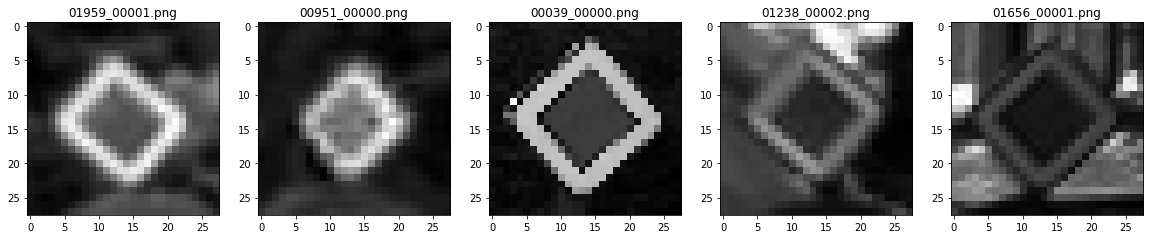

In [4]:
# This is just to test if image is loaded correctly


plt.figure(figsize=(20,20))
test_folder=r'./trafficsigns_dataset/diamond/rightofway'
for i in range(5):                                                    # Randomly loaded 5 images
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img, cmap = 'gray')

# **1. Data Preparation**
**Importing data into a dataframe**

Data will be stored in a dataframe which has image path, shape and type as columns.

In [5]:
image_list = []

for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True):
#     print(filepath)
    sign_shape = filepath.split('\\')[1]
    sign_type = filepath.split('\\')[2]
    image_list.append((filepath, sign_shape, sign_type ))
    
    
# create a dataframe
data = pd.DataFrame(data= image_list, columns=["image_path", 'sign_shape','sign_type'])

In [6]:
# inspecting the dataframe
data.head()

,image_path,sign_shape,sign_type
0,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,rightofway
1,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,rightofway
2,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,rightofway
3,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,rightofway
4,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,rightofway


In [7]:
# data shape
data.shape

(3699, 3)

In [8]:
print("numbers of shape:", len(data.sign_shape.unique()))
data.sign_shape.unique()

numbers of shape: 5


array(['diamond', 'hex', 'round', 'square', 'triangle'], dtype=object)

In [9]:
print("numbers of type:", len(data.sign_type.unique()))
data.sign_type.unique()

numbers of type: 16


array(['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry',
       'noparking', 'roundabout', 'speed', 'trafficdirective',
       'traveldirection', 'continue', 'crossing', 'laneend', 'parking',
       'giveway', 'warning'], dtype=object)

**Labels encoding**

Using label encoder from sklearn to transform label into integer

In [10]:
labelEncoder = LabelEncoder()
data.sign_shape = labelEncoder.fit_transform(data.sign_shape)
data.sign_type = labelEncoder.fit_transform(data.sign_type)

In [11]:
# inspecting the changes
data.head()

,image_path,sign_shape,sign_type
0,./trafficsigns_dataset\diamond\rightofway\0003...,0,9
1,./trafficsigns_dataset\diamond\rightofway\0003...,0,9
2,./trafficsigns_dataset\diamond\rightofway\0003...,0,9
3,./trafficsigns_dataset\diamond\rightofway\0003...,0,9
4,./trafficsigns_dataset\diamond\rightofway\0003...,0,9


**Distributions of shape and type**

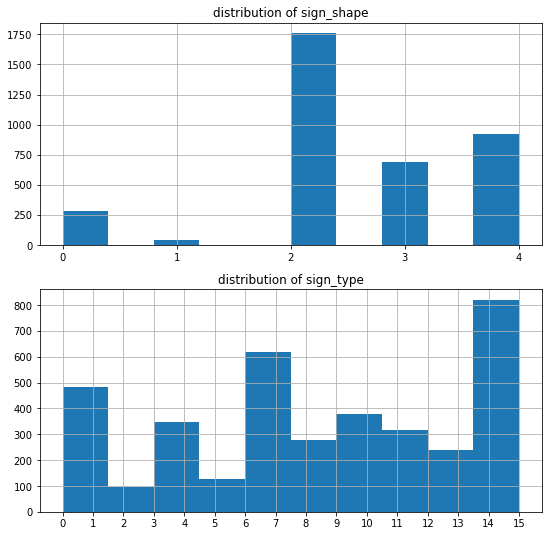

In [12]:
plt.figure(figsize=(9,9))
for i in range(1,3):
    plt.subplot(2,1,i)
    data.iloc[:, i].sort_values().astype(str).hist()
    txt = "distribution of " + data.columns[i]
    plt.title(txt)

**<u>Observation</u>:**

 * Data has multiple classes for shape and type of the traffic sign
 * Class imbalance problem in shape and type <br>
 * performance measure : F1, log_loss and average accuracy(micro-average)<br>

What is the realistic result for performance measure?

# **2. Model Development**
* Goal:
* Setup the experiment:
* Baseline Model:
* incremental changes:

In [13]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## **2.1 Image Data Generator**

### **2.1.1 Function to generate data**

In [14]:
class dataGenerator:
    def __init__(self, data, target_column_name):
        self.data = data
        self.target_column_name = target_column_name
        # Splitting input data into train, validation set
        self.path_train, self.path_validation = self.split_train_validation()
        print(f"Train data {target_column_name} : {self.path_train.shape[0]}\nVal Data {target_column_name}: {self.path_validation.shape[0]}")
        # Convert the target column into string array
        self.convert_target_column_to_String(self.path_train, self.path_validation)
        # Generating actual data from filepath
        self.train, self.validation = self.__generating_data_from_dataframe__()
   

    def split_train_validation(self):
        """
        Function to split input data into train, validation set
        """
        return train_test_split(self.data, random_state = random.randint(0, 100), test_size=0.2)

    def convert_target_column_to_String(self, train, validation):
        """
        Function to convert the refering target_column_name into string array
        """
        train.loc[:,self.target_column_name] = train.loc[:,self.target_column_name].astype('str')
        validation.loc[:, self.target_column_name] = validation.loc[:,self.target_column_name].astype('str')
    
    def __generating_data_from_dataframe__(self):
        """
        Function to generate actual data from file path
        """
        train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
        val_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
        batch_size = 32
        train = train_datagen.flow_from_dataframe(
            dataframe = self.path_train,
            directory = './',
            x_col = "image_path",
            y_col = self.target_column_name,
            target_size = (28, 28),
            batch_size = batch_size,
            class_mode = 'categorical')

        validation = val_datagen.flow_from_dataframe(
            dataframe = self.path_validation,
            directory = './',
            x_col = "image_path",
            y_col = self.target_column_name,
            target_size = (28, 28),
            batch_size = batch_size,
            class_mode = 'categorical')
        return train, validation


### **2.1.2 Shape**

Split data into train and validation set

In [15]:
dataShape = dataGenerator(data, "sign_shape")

Train data sign_shape : 2959
Val Data sign_shape: 740


C:\Users\Hoang\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


### **2.1.2 Type**

In [16]:
dataType = dataGenerator(data, "sign_type")

Train data sign_type : 2959
Val Data sign_type: 740
Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


## **2.2 Build Model**

In [17]:
input_dimension = (28,28,3)
numbers_of_shape = len(data.sign_shape.unique())
numbers_of_sign = len(data.sign_type.unique())

### **2.2.1 Multilayer Perceptron Neural Network**

#### 2.2.1.1 Shape

#### A. Baseline Model

In [18]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(320, activation='sigmoid'),
    tf.keras.layers.Dense(5, 'softmax')
])

**Compile model**

In [19]:
model.compile(optimizer = 'sgd',
              # use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])

**Train model**

In [20]:
history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)

C:\Users\Hoang\AppData\Local\Temp/ipykernel_17000/2574104595.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)


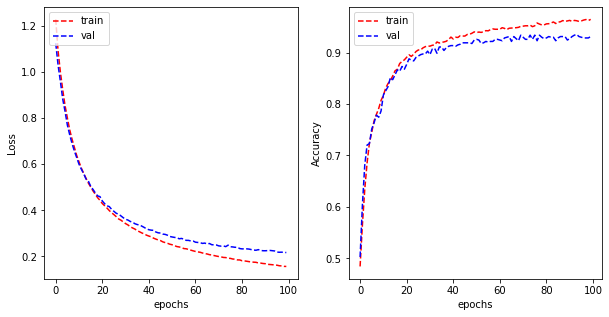

In [21]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

#### B. Hyperparameter Tuning Model

In [22]:
def parameters( layer, units, activation, dropout, lr,  numbers_of_label,  momentum):
    """
    
    """
    model = keras.Sequential([tf.keras.layers.Flatten(input_shape = input_dimension)])
    # Tune the number of layers
    for i in range(layer):
        model.add(layers.Dense(units=units, activation = activation))
    # tune dropout  
    if dropout:
        model.add(layers.Dropout(rate = 0.3))
    # output layer
    model.add(layers.Dense(numbers_of_label, activation = 'softmax'))
    
    # loss function
    model.compile(optimizer=keras.optimizers.SGD(learning_rate = lr,  
                                                momentum = momentum, nesterov = True),
                                                loss = 'CategoricalCrossentropy',
                                                metrics = ['categorical_accuracy'])
    return model


def build_model(hp):
    # Declaring the number of layers to be tuned
    layer = hp.Int("num_layers", 1, 3)
    # Declaring the number of units per layer to be tuned
    units = hp.Int("units", min_value = 16, max_value = 512, step = 16)
    # Declaring the activaiton functionto be tuned
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
    dropout = hp.Boolean('dropout')
    # Declaring the learning rate range to be tuned
    lr = hp.Float('lr', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    momentum = hp.Float('momentum', min_value = 0.1, max_value = 0.9, sampling = 'log' )
    model = parameters( layer = layer, units = units, activation = activation, dropout = dropout,
                    momentum = momentum, lr = lr, numbers_of_label = numbers_of_shape)    
    return model


build_model(kt.HyperParameters())

In [23]:
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective = "val_categorical_accuracy", 
    max_trials = 3,
    executions_per_trial = 2,
    overwrite = True,
    directory = "my_dir",
    project_name = "helloworld",
)

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': None, 'sampling': 'log'}


In [25]:
# create weight for imbalance class
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = data.sign_shape.unique(),
                                                 y = data.sign_shape.to_numpy())

# convert class_weights to dictionary
class_weight_dict = dict()
i = 0
for w in class_weights:
    class_weight_dict[i] = w
    i= i+1

In [26]:
tuner.search(dataShape.train, epochs=100, validation_data=dataShape.validation,class_weight=class_weight_dict , callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")])

Trial 3 Complete [00h 04m 01s]
val_categorical_accuracy: 0.9533783793449402

Best val_categorical_accuracy So Far: 0.958108127117157
Total elapsed time: 00h 15m 51s
INFO:tensorflow:Oracle triggered exit


In [27]:
# get best model and best hyper parameter
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]

In [28]:
#best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 128)               301184    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 318,341
Trainable params: 318,341
Non-trainable params: 0
_________________________________________________________________


In [29]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

In [30]:
model = tuner.hypermodel.build(best_hp)
history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)

C:\Users\Hoang\AppData\Local\Temp/ipykernel_17000/2324079621.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)


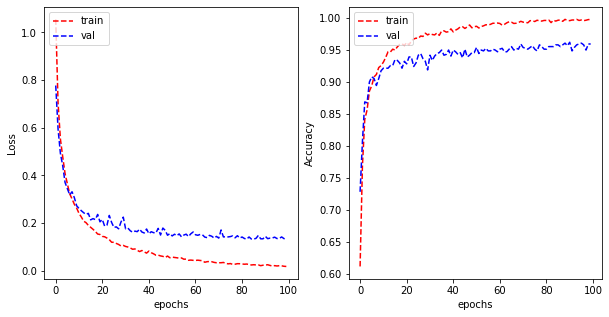

In [31]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [32]:
# get the best epoch
val_acc_per_epoch = history.history['val_categorical_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 91


In [33]:
# Retrain the model with the best epoch
finale_model = tuner.hypermodel.build(best_hp)

finale_model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=best_epoch, verbose=0)

C:\Users\Hoang\AppData\Local\Temp/ipykernel_17000/71869514.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  finale_model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=best_epoch, verbose=0)


#### 2.2.1.2 Type

### **2.2.2 Convolution Neural Network**

#### A. Simple CNN Model

In [34]:
model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
    ])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [35]:
model.compile(optimizer = 'sgd',
              # use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])

In [36]:
history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)

C:\Users\Hoang\AppData\Local\Temp/ipykernel_17000/2574104595.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)


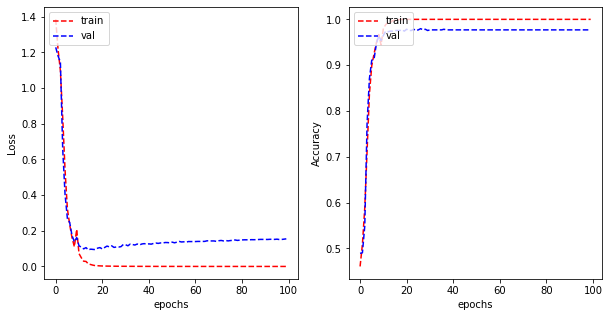

In [37]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/keras_tuner/

https://keras.io/guides/keras_tuner/visualize_tuning/

https://www.tensorflow.org/tutorials/keras/keras_tuner

Hoang check links for documentation on tuner